<h2> 2. Value-at-Risk </h2>

### A: Calculating Risk Measures

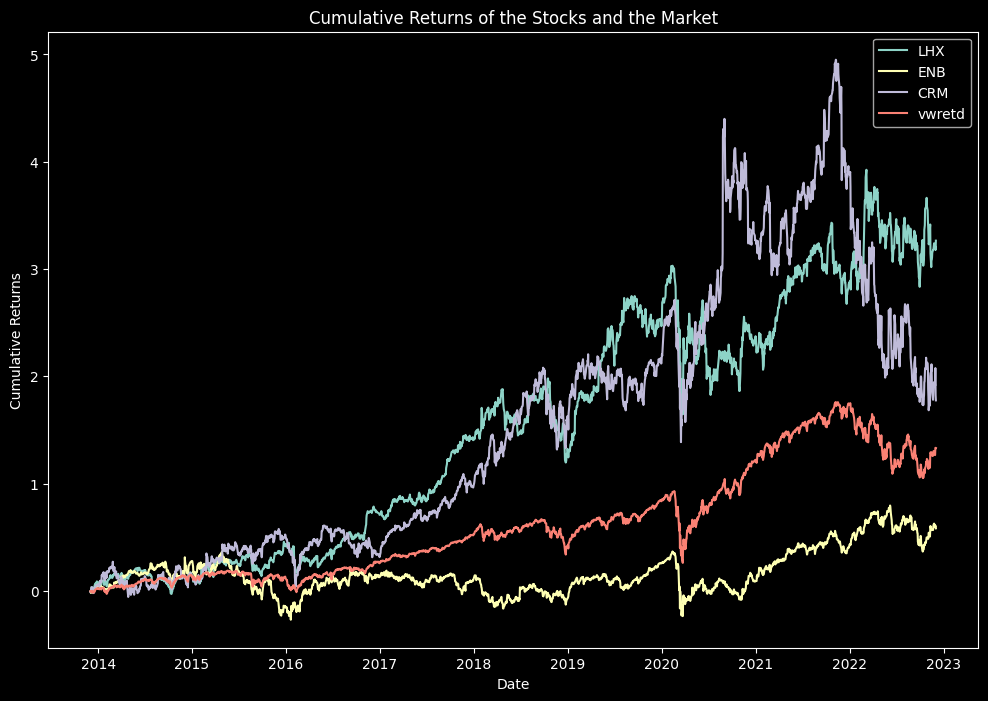

,LHX,ENB,CRM,vwretd
count,2268.000000,2268.000000,2268.000000,2268.000000
mean,0.000768,0.000354,0.000694,0.000437
std,0.016020,0.017395,0.022152,0.011239
min,-0.142994,-0.178327,-0.158885,-0.118168
25%,-0.006576,-0.007699,-0.008943,-0.003801
50%,0.000978,0.000629,0.000845,0.000675
75%,0.008304,0.008515,0.011462,0.005558
max,0.118680,0.191448,0.260449,0.091556


In [1]:
# import packages 
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import norm, binom
from numpy.random import default_rng
import matplotlib.pyplot as plt
from scipy.stats import probplot
from scipy.stats import kstest, norm
from numpy.random import choice

# Formatting
returns_data = pd.read_csv('Data/Stocks and Market Returns.csv', index_col=0, parse_dates=True)

# Calculate cumulative returns of the stocks and market in order to plot them in a meaningful way
cumulative_returns = (1 + returns_data).cumprod() - 1

# Plot the cumulative returns
plt.figure(figsize=(12, 8))  # Set the figure size
for column in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[column], label=column)
plt.xlabel('Date')  # Set the x-axis label
plt.ylabel('Cumulative Returns')  # Set the y-axis label
plt.title('Cumulative Returns of the Stocks and the Market')  # Set the title
plt.legend()  # Show the legend
plt.show()  # Display the plot

# Calculate descriptive statistics of the returns
returns_data.describe()


In [2]:
# Retrieve the cumulative return for '2022-12-02'
cumulative_return_on_2022_12_02 = cumulative_returns.loc['2022-12-02']
cumulative_return_on_2022_12_02

LHX       3.263849
ENB       0.582586
CRM       1.775165
vwretd    1.331466
Name: 2022-12-02 00:00:00, dtype: float64

### B: VaR and ES Estimates

In [3]:
# Define the function to calculate VaR and ES
def calculate_var_es(returns, alpha):
    VaR = np.quantile(returns, alpha)
    ES = returns[returns < VaR].mean()

    # Verify that alpha is within the correct range
    if not 0 < alpha < 1:
        raise ValueError()
    
    return VaR, ES

# Define the confidence level
alpha = 0.05 

# Calculate and print VaR and ES for each column
for column in returns_data.columns:
    var, es = calculate_var_es(returns_data[column].values, alpha)
    print(f"{column}: VaR: {var:.2%}, ES: {es:.2%}")

LHX: VaR: -2.37%, ES: -3.66%
ENB: VaR: -2.49%, ES: -3.90%
CRM: VaR: -3.44%, ES: -5.02%
vwretd: VaR: -1.69%, ES: -2.78%


### C: Parametric Estimates

In [4]:
# Define a list of stock tickers
tickers = ['LHX', 'ENB', 'CRM']

# dictionary to hold the OLS results and VaR values
ols_results = {}
var_results = {}


# Define the function to calculate VaR
def calculate_var_ols(regression_results, p):
    # Verify that p is within the correct range
    if not 0 < p < 1:
        raise ValueError("p must be between 0 and 1.")
    
    # Find the scale parameter from the regression model (standard deviation of the residuals)
    sigma_hat = regression_results.scale ** 0.5
    
    # Find the mean of the fitted values
    mean_fitted = regression_results.fittedvalues.mean()
    
    # Use the PPF of the normal distribution at the desired quantile
    VaR = mean_fitted + norm.ppf(p) * sigma_hat

    return VaR

# Define the confidence level
p = 0.05

# Loop through each ticker, perform OLS, and calculate VaR
for ticker in tickers:
    # Perform OLS regression
    ols_result = sm.OLS(returns_data[ticker], sm.add_constant(returns_data['vwretd'])).fit()
    ols_results[ticker] = ols_result
    
    # Calculate VaR for each regression result
    var_results[ticker] = calculate_var_ols(ols_result, p)

# Display the results
for ticker, var_value in var_results.items():
    print(f"VaR for {ticker}: {var_value:.2%}")


VaR for LHX: -2.15%
VaR for ENB: -2.24%
VaR for CRM: -2.68%


### D: Parametric Estimates with Adjusted Error

In [5]:
# Dictionary to hold, VaR values, and variances
var_results_D = {}
variance_results_D = {}  # New dictionary to store variances

# Define the confidence level
p = 0.05

# Define the function to calculate VaR and variance using the new model
def calculate_var_new_model(regression_results, p):
    # Verify that p is within the correct range
    if not 0 < p < 1:
        raise ValueError("p must be between 0 and 1.")

    # Find the OLS estimate of the variance
    sigma_OLS_squared = regression_results.scale

    # Initialize the array for the conditional variances
    variances = np.empty(len(regression_results.resid))
    variances[0] = sigma_OLS_squared  # Starting value for variance

    # Calculate the variance for each time t using the recursive formula
    for t in range(1, len(regression_results.resid)):
        variances[t] = (sigma_OLS_squared + variances[t-1]) / 2

    # Store the final variance for later use
    final_variance = variances[-1]

    # Calculate the standard deviation for the last time period
    sigma_t = np.sqrt(final_variance)

    # Use the PPF of the normal distribution at the desired quantile
    VaR = regression_results.fittedvalues.mean() + norm.ppf(p) * sigma_t

    return VaR, final_variance

# Loop through each ticker, perform OLS, and calculate VaR and variance
for ticker in tickers:
    # Perform OLS regression
    ols_result = sm.OLS(returns_data[ticker], sm.add_constant(returns_data['vwretd'])).fit()
    ols_results[ticker] = ols_result

    # Calculate VaR and variance for each regression result using the new model
    var_results_D[ticker], variance_results_D[ticker] = calculate_var_new_model(ols_result, p)

# Display the results
for ticker in tickers:
    print(f"VaR for {ticker}: {var_results_D[ticker]:.2%}")
    print(f"Variance for {ticker}: {variance_results_D[ticker]:.10f}")

VaR for LHX: -2.15%
Variance for LHX: 0.0001827720
VaR for ENB: -2.24%
Variance for ENB: 0.0001913013
VaR for CRM: -2.68%
Variance for CRM: 0.0002800552


### E: null hypothesis for value-at-risk

In [6]:
def var_coverage_test(returns, var_estimate, alpha):
    # Calculate the hit series (1 when loss exceeds VaR)
    hits = returns < -var_estimate
    hit_count = hits.sum()

    # Number of observations
    n = len(returns)
    
    # Test statistic calculation
    test_statistic = (hit_count - (n * alpha)) / np.sqrt(n * alpha * (1 - alpha))
    
    # Calculate the two-tailed p-value for the binomial test
    p_value_low = binom.cdf(hit_count, n, alpha)
    p_value_high = binom.sf(hit_count-1, n, alpha)
    p_value = 2 * min(p_value_low, p_value_high)
    if p_value > 1:
        p_value = 2 - p_value

    return test_statistic, p_value

# Perform the coverage test for each stock
coverage_results = {}
for ticker in returns_data.columns[:-1]:  # Assume the last column is 'vwretd', which we skip
    returns = returns_data[ticker]
    var_estimate = var_results[ticker]
    test_statistic, p_value = var_coverage_test(returns, var_estimate, alpha)
    coverage_results[ticker] = {'Test Statistic': test_statistic, 'P-Value': p_value}

# Print the results
for ticker, results in coverage_results.items():
    print(f"{ticker} VaR coverage test results:")
    print(f"  Test Statistic: {results['Test Statistic']:.4f}")
    print(f"  P-Value: {results['P-Value']:.4f}")

LHX VaR coverage test results:
  Test Statistic: 194.5795
  P-Value: 0.0000
ENB VaR coverage test results:
  Test Statistic: 194.0977
  P-Value: 0.0000
CRM VaR coverage test results:
  Test Statistic: 191.4001
  P-Value: 0.0000


### F: Wald-Wolfowitz statistic as well as its p-value

In [7]:
# Define the function for the Wald-Wolfowitz runs test
def wald_wolfowitz_runs_test(returns, var_estimate):
    # Convert returns to a binary sequence
    binary_sequence = np.array(returns) < -var_estimate
    n1 = binary_sequence.sum()  # Number of negative data points
    n2 = len(binary_sequence) - n1  # Number of positive data points
    
    # Calculate the expected number of runs under randomness
    R_bar = ((2 * n1 * n2) / (n1 + n2)) + 1
    
    # Calculate the standard deviation of runs under randomness
    sigma_R = np.sqrt((2 * n1 * n2 * (2 * n1 * n2 - n1 - n2)) / ((n1 + n2)**2 * (n1 + n2 - 1)))
    
    # Count the actual number of runs
    runs = 1 + np.sum(binary_sequence[1:] != binary_sequence[:-1])  # 1 for the first run + number of changes
    
    # Calculate the z-statistic
    z = (runs - R_bar) / sigma_R
    
    # Calculate the two-tailed p-value
    p_value = 2 * (1 - norm.cdf(abs(z)))
    
    return z, p_value

# Apply the Wald-Wolfowitz runs test to each stock using the calculated VaR
runs_test_results = {}
for ticker in tickers:
    returns = returns_data[ticker]
    z, p_value = wald_wolfowitz_runs_test(returns, var_estimate)
    runs_test_results[ticker] = {'Z-Statistic': z, 'P-Value': p_value}

# Print the Wald-Wolfowitz runs test results
for ticker in runs_test_results:
    print(f"{ticker} Wald-Wolfowitz runs test results:")
    print(f"  Z-Statistic: {runs_test_results[ticker]['Z-Statistic']:.4f}")
    print(f"  P-Value: {runs_test_results[ticker]['P-Value']:.4f}")

LHX Wald-Wolfowitz runs test results:
  Z-Statistic: -2.8866
  P-Value: 0.0039
ENB Wald-Wolfowitz runs test results:
  Z-Statistic: -5.8840
  P-Value: 0.0000
CRM Wald-Wolfowitz runs test results:
  Z-Statistic: -2.0098
  P-Value: 0.0445


<h2> 3. Simulations </h2>

<h3> A. Function that returns 1-D Array of 200 i.i.d. draws </h3>

In [8]:
def t_draw_200(BG, degrees):
    return BG.standard_t(degrees, size=200) # Draw 200 samples from a t-distribution with the specified degrees of freedom

print(t_draw_200(np.random.default_rng(), 5))

[-4.05362836e-03 -9.45685943e-01  7.58345755e-01  5.88030048e-01
 -1.10924334e+00  1.12040399e-02 -1.11817274e+00  4.05444607e-01
 -2.01137944e+00  7.61387815e-01  6.01746331e-01  1.29617133e+00
  3.22282583e-01  2.93675574e-01 -4.61761479e-01 -5.47734002e-01
  1.65041012e+00  7.91033944e-01  2.83774963e+00 -5.36927076e-02
  7.94478649e-01 -5.58460602e-01  7.60140801e-01  6.34209461e-01
  7.02457386e-01 -7.80417717e-01 -8.01391153e-01  1.11540822e+00
 -7.88846564e-01 -4.81613182e-01  1.37461514e+00 -1.24828285e-01
  3.83351900e-01 -1.42485969e-01 -5.31877505e-01  8.38583991e-01
  1.23015034e+00 -2.56145390e-02 -9.60504124e-01 -4.10241479e-02
 -1.93924220e+00  1.51265003e+00  1.86986129e+00  6.65039235e-01
 -2.26298542e-02 -1.25273633e+00  1.67358668e-01  6.21908548e-01
  1.87719966e+00  9.12845650e-01 -6.20729482e+00 -3.06319095e-01
  1.96743335e+00 -1.08204802e+00 -6.14405651e-01 -3.61885412e-01
  1.28066564e-01 -1.44387683e+00  4.97116825e-02 -1.26826181e+00
  5.41961180e-01 -1.97563

<h3> B. Function that returns 1-D array dependent on replacement parameter </h3>

In [9]:
def BGAR(bg, a, r: bool):
    return bg.choice(a, size=len(a), replace=r) # Draw a sample from the specified array with replacement parameter

Testing code using 1 example Array:

In [10]:
example_array = np.random.standard_t(5, size=10)

BGAR1 = BGAR(np.random.default_rng(), example_array, True) # Draw random samples with replacement
BGAR2 = BGAR(np.random.default_rng(), example_array, False) # Draw random samples without replacement

print(f"Random Draws with Replacement: {BGAR1}")
print(f"Random Draws without Replacement: {BGAR2}")

Random Draws with Replacement: [ 0.08054346  1.0304834   0.50385592 -0.93857992  0.08054346 -2.98982735
  0.50385592 -1.134169    0.50385592  0.89455171]
Random Draws without Replacement: [ 0.50385592 -1.134169   -2.98982735  2.02049787  1.0304834  -0.59523431
 -0.93857992 -0.56140345  0.08054346  0.89455171]


<h3> C. Function that returns probaility plot of 1-D array vs. a N(0,1) distribution. </h3>

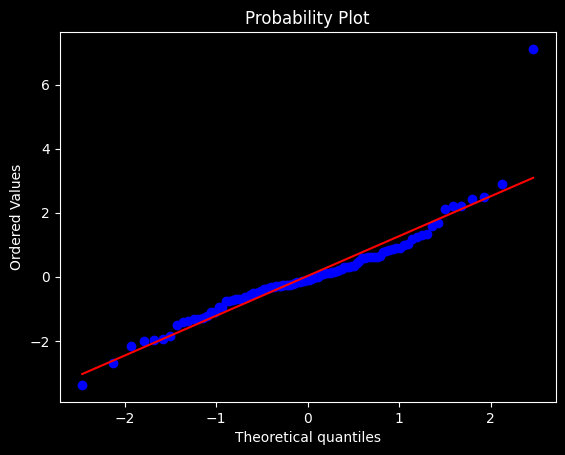

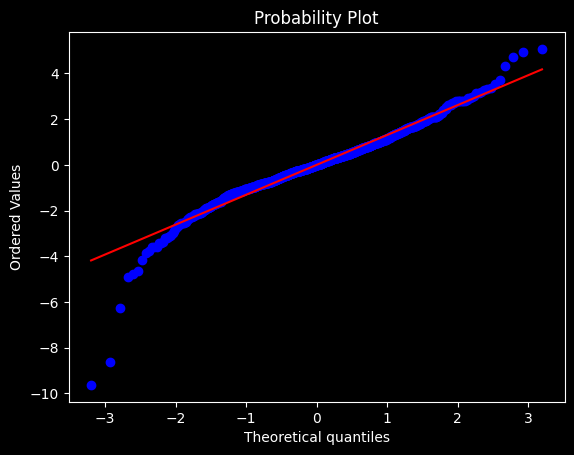

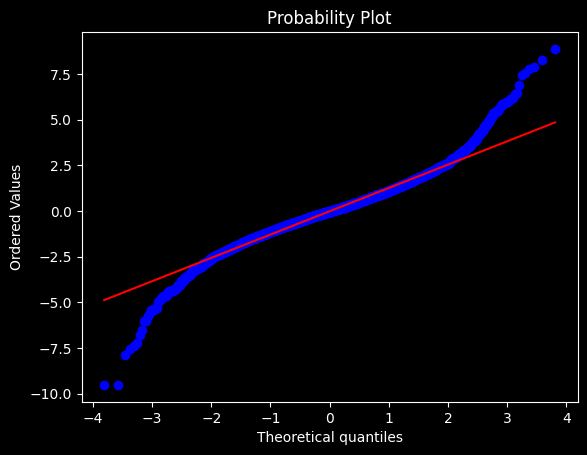

In [11]:
def pplot(s):
    probplot(s, dist="norm", plot=plt) # Create a probability plot of sample data against the quantiles of a normal distribution
    plt.show()


pplot(np.random.default_rng().standard_t(5, size=100))
pplot(np.random.default_rng().standard_t(5, size=1000))
pplot(np.random.default_rng().standard_t(5, size=10000))

<h3> D. Function that returns probability of rejecting H0 of a Kolmogorov-Smirnov test dependent on 1-D array. </h3>

In [12]:
def BGAT(bg, a, T: int):
    count = 0 # Initialize the count of p-values less than 0.05
    for _ in range(T): # Loop through the number of iterations
        boot = bg.choice(a, size=len(a), replace=True) # Draw a sample from the specified array with replacement
        p_value = kstest(boot, 'norm', args=(0, 1)).pvalue # Perform the Kolmogorov-Smirnov test and retrieve the p-value
        if p_value < 0.05: # Check if the p-value is less than 0.05
            count += 1 # Increment the count
    return count / T # Return the proportion of p-values less than 0.05

Testing code with 3 different arrays (power):

In [13]:

example_array1 = np.random.standard_t(5, size=100)
example_array2 = np.random.standard_t(5, size=1000)
example_array3 = np.random.standard_t(5, size=10000)  
probability_count = 5

results = []

print("Results for Array 1:")
for i in range(probability_count):
    rng = np.random.default_rng()
    result = BGAT(rng, example_array1, 1000)
    
    results.append(result)
    
    # Print the result
    print(f"{i+1}. Probability H0 is rejected at a 5% significance level: {result}")
print("\nResults for Array 2:")
for i in range(probability_count):
    rng = np.random.default_rng()
    result = BGAT(rng, example_array2, 1000)
    
    results.append(result)
    
    # Print the result
    print(f"{i+1}. Probability H0 is rejected at a 5% significance level: {result}")
print("\nResults for Array 3:")
for i in range(probability_count):
    rng = np.random.default_rng()
    result = BGAT(rng, example_array3, 1000)
    
    results.append(result)
    
    # Print the result
    print(f"{i+1}. Probability H0 is rejected at a 5% significance level: {result}")


Results for Array 1:
1. Probability H0 is rejected at a 5% significance level: 0.303
2. Probability H0 is rejected at a 5% significance level: 0.341
3. Probability H0 is rejected at a 5% significance level: 0.307
4. Probability H0 is rejected at a 5% significance level: 0.311
5. Probability H0 is rejected at a 5% significance level: 0.3

Results for Array 2:
1. Probability H0 is rejected at a 5% significance level: 0.882
2. Probability H0 is rejected at a 5% significance level: 0.875
3. Probability H0 is rejected at a 5% significance level: 0.883
4. Probability H0 is rejected at a 5% significance level: 0.909
5. Probability H0 is rejected at a 5% significance level: 0.9

Results for Array 3:
1. Probability H0 is rejected at a 5% significance level: 1.0
2. Probability H0 is rejected at a 5% significance level: 1.0
3. Probability H0 is rejected at a 5% significance level: 1.0
4. Probability H0 is rejected at a 5% significance level: 1.0
5. Probability H0 is rejected at a 5% significance 

Testing size:

In [14]:

example_array1 = np.random.standard_t(1, size=1000)
example_array2 = np.random.standard_t(5, size=1000)
example_array3 = np.random.standard_t(10, size=1000)  
probability_count = 5

results = []

print("Results for Array 1:")
for i in range(probability_count):
    rng = np.random.default_rng()
    result = BGAT(rng, example_array1, 1000)
    
    results.append(result)
    
    # Print the result
    print(f"{i+1}. Probability H0 is rejected at a 1% significance level: {result}")
print("\nResults for Array 2:")
for i in range(probability_count):
    rng = np.random.default_rng()
    result = BGAT(rng, example_array2, 1000)
    
    results.append(result)
    
    # Print the result
    print(f"{i+1}. Probability H0 is rejected at a 5% significance level: {result}")
print("\nResults for Array 3:")
for i in range(probability_count):
    rng = np.random.default_rng()
    result = BGAT(rng, example_array3, 1000)
    
    results.append(result)
    
    # Print the result
    print(f"{i+1}. Probability H0 is rejected at a 10% significance level: {result}")

Results for Array 1:
1. Probability H0 is rejected at a 1% significance level: 1.0
2. Probability H0 is rejected at a 1% significance level: 1.0
3. Probability H0 is rejected at a 1% significance level: 1.0
4. Probability H0 is rejected at a 1% significance level: 1.0
5. Probability H0 is rejected at a 1% significance level: 1.0

Results for Array 2:
1. Probability H0 is rejected at a 5% significance level: 0.658
2. Probability H0 is rejected at a 5% significance level: 0.647
3. Probability H0 is rejected at a 5% significance level: 0.629
4. Probability H0 is rejected at a 5% significance level: 0.642
5. Probability H0 is rejected at a 5% significance level: 0.649

Results for Array 3:
1. Probability H0 is rejected at a 10% significance level: 0.177
2. Probability H0 is rejected at a 10% significance level: 0.192
3. Probability H0 is rejected at a 10% significance level: 0.175
4. Probability H0 is rejected at a 10% significance level: 0.201
5. Probability H0 is rejected at a 10% signif

<h2> 4. Combining Simulations and Value-at-Risk </h2>

/var/folders/vw/nq14zj9x7pq7w3w49n_1v_n40000gn/T/ipykernel_68985/1182285116.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  var_results_df = pd.concat([var_results_df, result_row], ignore_index=True)


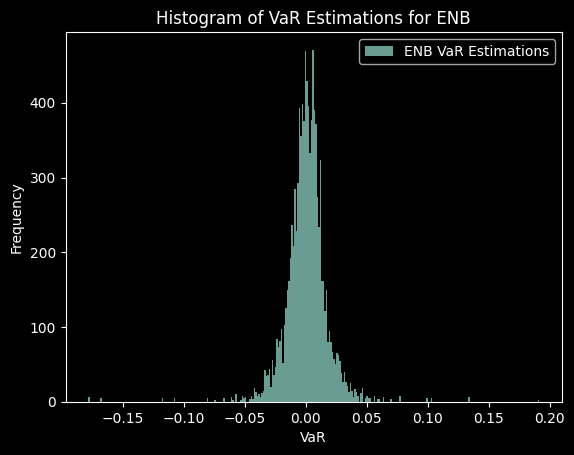

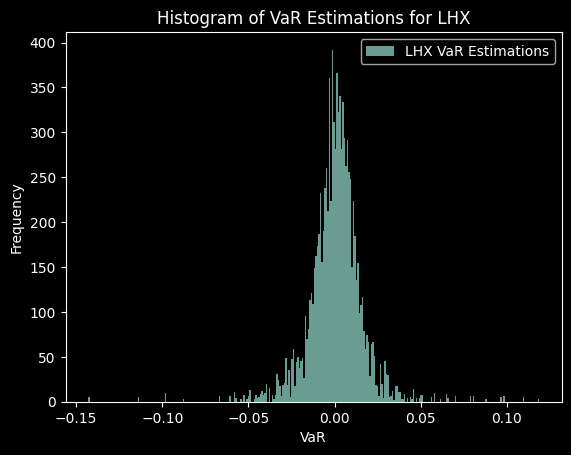

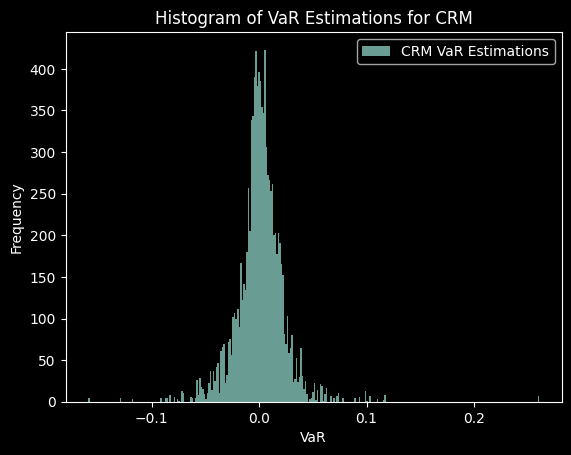

            VaR  95% CI Lower  95% CI Upper
Stock                                      
ENB   -0.024070     -0.031313      0.032332
LHX   -0.024045     -0.031932      0.030423
CRM   -0.034462     -0.044576      0.041704


In [15]:

def simulate_var_and_confidence_intervals(returns, seed=42):
    np.random.seed(seed)
    bootstrap_samples = np.random.choice(returns, size=(10000), replace=True)
    var_5_percentile = np.percentile(bootstrap_samples, 5)
    ci_lower = np.percentile(bootstrap_samples, 2.5)
    ci_upper = np.percentile(bootstrap_samples, 97.5)
    return var_5_percentile, ci_lower, ci_upper, bootstrap_samples

returns_data = pd.read_csv('Data/Stocks and Market Returns.csv', index_col=0, parse_dates=True)
stocks = returns_data[['ENB', 'LHX', 'CRM']]

var_results_df = pd.DataFrame(columns=['Stock', 'VaR', '95% CI Lower', '95% CI Upper'])

for stock in stocks:
    returns = stocks[stock].dropna()
    var_5_percentile, ci_lower, ci_upper, samples = simulate_var_and_confidence_intervals(returns)
    
    result_row = pd.DataFrame({
        'Stock': [stock], 
        'VaR': [var_5_percentile], 
        '95% CI Lower': [ci_lower], 
        '95% CI Upper': [ci_upper]
    })

    # Drop empty or all-NA columns from the result_row DataFrame
    result_row = result_row.dropna(axis=1, how='all')

    # Concatenate the result_row DataFrame with the var_results_df DataFrame
    var_results_df = pd.concat([var_results_df, result_row], ignore_index=True)

    plt.hist(samples, bins=300, alpha=0.75, label=f'{stock} VaR Estimations')
    plt.title(f'Histogram of VaR Estimations for {stock}')
    plt.xlabel('VaR')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

print(var_results_df.set_index('Stock'))